### Import libraries

In [3]:
# Libraries 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### Customization 

In [5]:
# Specify output files
my_payoff= "0512 detailed_payoff.csv"
my_decision_tree= "0512 decision_tree.png"

# Define probabilities of tourist inflow scenarios
tourist_scenarios = {"Low": 0.2, "Medium": 0.4, "High": 0.4}
sales_volume = {"Low": 100, "Medium": 150, "High": 200}

# Define reorder sizes
reorder_sizes = [100, 150, 200]

# Define cost parameters
cost_per_unit = 10
price_per_unit = 20
penalty_per_unit = 2  # Penalty for excess stock returns
rush_cost_per_unit = 5  # Extra cost for stockouts

### Create cost computation function 

In [7]:
# Function to compute net profit with corrected cost computation
def calculate_corrected_profit(reorder_size, inflow):
    demand = sales_volume[inflow]
    
    # Sales revenue based on actual demand
    revenue = demand * price_per_unit
    
    # Cost of goods for the entire demand (not just reorder size)
    cost = demand * cost_per_unit
    
    # Handling excess stock (penalty) or stockouts (rush cost)
    if reorder_size > demand:
        excess = reorder_size - demand
        penalty = excess * penalty_per_unit  # Cost of returning excess stock
        rush_cost = 0  # No rush cost as supply meets/exceeds demand
    else:
        excess = 0
        penalty = 0
        stockout = demand - reorder_size
        rush_cost = stockout * rush_cost_per_unit  # Cost of rushed stock

    # Net profit calculation
    net_profit = revenue - cost - penalty - rush_cost
    
    # Return detailed breakdown
    return {
        "Reorder Size": reorder_size,
        "Tourist Inflow": inflow,
        "Demand": demand,
        "Revenue": revenue,
        "Cost (for Demand)": cost,
        "Excess Stock": excess,
        "Penalty Cost": penalty,
        "Stockout": stockout if reorder_size < demand else 0,
        "Rush Cost": rush_cost,
        "Net Profit": net_profit
    }

### Adjust for probabilities  

In [9]:
# Compute corrected detailed computations for all scenarios
corrected_detailed_computations = []
for reorder in reorder_sizes:
    for inflow in tourist_scenarios:
        result = calculate_corrected_profit(reorder, inflow)
        result["Probability"] = tourist_scenarios[inflow]
        result["Weighted Profit"] = result["Net Profit"] * tourist_scenarios[inflow]
        corrected_detailed_computations.append(result)

### Display summary and save payoff table in CSV file 

In [11]:
# Convert to DataFrame and save
corrected_detailed_computations_df = pd.DataFrame(corrected_detailed_computations)
corrected_detailed_computations_df.to_csv(my_payoff, index=False)

# Create payoff table with expected values for each reorder size
payoff_table = corrected_detailed_computations_df.groupby("Reorder Size")[["Weighted Profit"]].sum().reset_index()

# Display payoff at each level of reorder
print("Payoff Table:")
print(payoff_table.to_string(index=False))

# Find the best decision (highest expected profit)
best_decision = payoff_table.loc[payoff_table["Weighted Profit"].idxmax()]

### Create visualization 

# Visualization using NetworkX
def draw_decision_tree():
    G = nx.DiGraph()
    
    # Root node (decision point)
    G.add_node("Reorder Decision")
    
    # Add branches for each reorder size
    for reorder in reorder_sizes:
        reorder_node = f"Reorder {reorder}"
        G.add_edge("Reorder Decision", reorder_node)
        
        # Add branches for tourist inflow scenarios
        for inflow in tourist_scenarios.keys():
            inflow_node = f"{reorder_node} -> {inflow}"
            G.add_edge(reorder_node, inflow_node)
            
            # Add expected profit at each leaf node
            result = calculate_corrected_profit(reorder, inflow)
            profit_node = f"Profit: {result['Net Profit']:.2f}"
            G.add_edge(inflow_node, profit_node)
    
    plt.figure(figsize=(14, 10))
    pos = nx.circular_layout(G)  
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=6000, font_size=14)
    plt.title("Decision Tree for Reorder Level")
    
    # Save the decision tree graphic
    plt.savefig(my_decision_tree)
    plt.show()


Payoff Table:
 Reorder Size  Weighted Profit
          100           1300.0
          150           1480.0
          200           1520.0


### Draw decision tree and save file

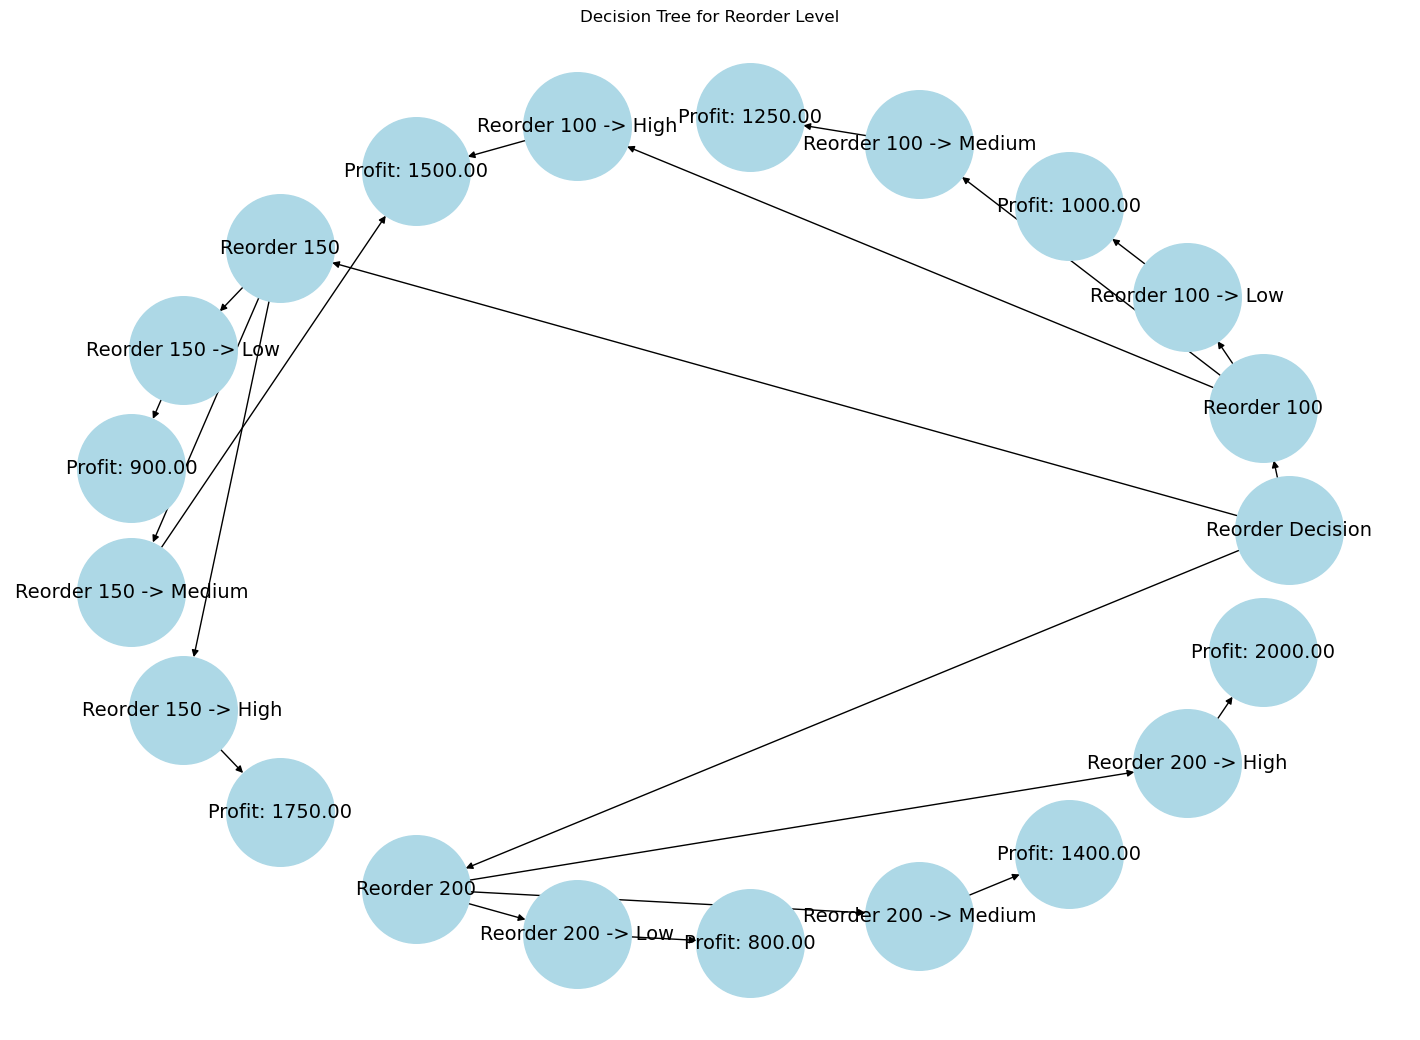

Best reorder size: 200.0, Expected Profit: 1520.00


In [13]:
# Draw and save the decision tree graphic
draw_decision_tree()

# Display the best decision
print(f"Best reorder size: {best_decision['Reorder Size']}, Expected Profit: {best_decision['Weighted Profit']:.2f}")